### TASK: Create Encder-Decoder LSTM model to convert English sentences to Hindi sentences.  
We are going to use word level embedding

In [1]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

#Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preparing Data

### 1 .  Import Libraries

In [3]:

#%tensorflow_version 2.x

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers , activations , models , preprocessing , utils
import pandas as pd


### 2 . Read Data


In [4]:
!wget http://www.manythings.org/anki/hin-eng.zip -O hin-eng.zip

## IIT dataset : https://www.cfilt.iitb.ac.in/iitb_parallel/iitb_corpus_download/parallel.zip

!unzip hin-eng.zip


--2022-09-15 15:59:33--  http://www.manythings.org/anki/hin-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131711 (129K) [application/zip]
Saving to: ‘hin-eng.zip’

hin-eng.zip         100%[===================>] 128.62K   275KB/s    in 0.5s    

2022-09-15 15:59:34 (275 KB/s) - ‘hin-eng.zip’ saved [131711/131711]

Archive:  hin-eng.zip
  inflating: hin.txt                 
  inflating: _about.txt              


In [5]:
lines = pd.read_table( 'hin.txt' , names=[ 'eng' , 'hindi' ] )
lines.reset_index( level=0 , inplace=True )
lines.rename( columns={ 'index' : 'eng' , 'eng' : 'hindi' , 'hindi' : 'c' } , inplace=True )
lines = lines.drop( 'c' , 1 )

lines.tail()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


,eng,hindi
2904,"If you go to that supermarket, you can buy mos...",उस सूपरमार्केट में तुम लगभग कोई भी रोजाने में ...
2905,The passengers who were injured in the acciden...,जिन यात्रियों को दुर्घटना मे चोट आई थी उन्हे अ...
2906,"Democracy is the worst form of government, exc...","लोकतंत्र सरकार का सबसे घिनौना रूप है, अगर बाकी..."
2907,If my boy had not been killed in the traffic a...,अगर मेरा बेटा ट्रेफ़िक हादसे में नहीं मारा गया...
2908,"When I was a kid, touching bugs didn't bother ...","जब मैं बच्चा था, मुझे कीड़ों को छूने से कोई पर..."


#Set Data Size

In [6]:
lines= lines[:2908]
lines.count()

eng      2908
hindi    2908
dtype: int64

### 3) Preparing input data for the Encoder ( `encoder_input_data` )
The Encoder model will be fed input data which are **preprocessed English sentences**. Following preprocessing is done:


1.   Tokenizing the Hindi sentences from `hindi_lines`.
2.   Determining the maximum length of the Hindi sentence that's `max_input_length`.
3.   Padding the `tokenized_hindi_lines` to the max_input_length.
4.   Determining the vocabulary size ( `num_hindi_tokens` ) for English words.





In [7]:
hindi_lines = list()
for line in lines.hindi:
    hindi_lines.append( line ) 

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts( hindi_lines ) 
tokenized_hindi_lines = tokenizer.texts_to_sequences( hindi_lines ) 

length_list = list()
for token_seq in tokenized_hindi_lines:
    length_list.append( len( token_seq ))
max_input_length = np.array( length_list ).max()
print( 'Hindi max length is {}'.format( max_input_length ))

padded_hindi_lines = preprocessing.sequence.pad_sequences( tokenized_hindi_lines , maxlen=max_input_length , padding='post' )
encoder_input_data = np.array( padded_hindi_lines )
print( 'Encoder input data shape -> {}'.format( encoder_input_data.shape ))

hindi_word_dict = tokenizer.word_index
num_hindi_tokens = len( hindi_word_dict )+1
print( 'Number of Hindi tokens = {}'.format( num_hindi_tokens))

# print("Dictionary Eng word to tokens", eng_word_dict)














"""
Oov tokens are out of vocabulary tokens used to replace unknown words.
"""

Hindi max length is 21
Encoder input data shape -> (2908, 21)
Number of Hindi tokens = 3011


'\nOov tokens are out of vocabulary tokens used to replace unknown words.\n'

### 4) Preparing input data for the Decoder ( `decoder_input_data` )
The Decoder model will be fed the preprocessed Hindi lines. Preprocessing steps are similar to the ones which are above. This one step is carried out before the other steps.


*   Append `<START>` tag at the first position in  each Hindi sentence.
*   Append `<END>` tag at the last position in  each Hindi sentence.





In [8]:

eng_lines = list()
for line in lines.eng:
    eng_lines.append( '<START> ' + line + ' <END>' )  

tokenizer = preprocessing.text.Tokenizer(oov_token=1)
tokenizer.fit_on_texts( eng_lines ) 
tokenized_eng_lines = tokenizer.texts_to_sequences( eng_lines ) 

length_list = list()
for token_seq in tokenized_eng_lines:
    length_list.append( len( token_seq ))
max_output_length = np.array( length_list ).max()
print( 'English max length is {}'.format( max_output_length ))

padded_eng_lines = preprocessing.sequence.pad_sequences( tokenized_eng_lines , maxlen=max_output_length, padding='post' )
decoder_input_data = np.array( padded_eng_lines  )
print( 'Decoder input data shape -> {}'.format( decoder_input_data.shape ))

eng_word_dict = tokenizer.word_index
num_eng_tokens = len( eng_word_dict )+1
print( 'Number of English tokens = {}'.format( num_eng_tokens))

# print("Dictionary Hindi word to tokens", hindi_word_dict)


English max length is 20
Decoder input data shape -> (2908, 20)
Number of English tokens = 2394


### 5) Preparing target data for the Decoder ( decoder_target_data ) 

We take a copy of `tokenized_hindi_lines` and modify it like this.



1.  Remove the `<start>` tag which we appended earlier. Hence, the word ( which is `<start>` in this case  ) will be removed.
2.   Convert the `padded_hindi_lines` ( ones which do not have `<start>` tag ) to one-hot vectors.

For example :

```
 [ '<start>' , 'hello' , 'world' , '<end>' ]

```

wil become 

```
 [ 'hello' , 'world' , '<end>' ]

```


In [9]:

decoder_target_data = list()
for token_seq in tokenized_eng_lines:
    decoder_target_data.append( token_seq[ 1 : ] ) 
    
padded_eng_lines = preprocessing.sequence.pad_sequences( decoder_target_data , maxlen=max_output_length, padding='post' )
onehot_eng_lines = utils.to_categorical( padded_eng_lines , num_eng_tokens )
decoder_target_data = np.array( onehot_eng_lines )
print( 'Decoder target data shape -> {}'.format( decoder_target_data.shape ))


Decoder target data shape -> (2908, 20, 2394)


### 1) Defining the Encoder-Decoder model
The model will have Embedding, LSTM and Dense layers. The basic configuration is as follows.


*   2 Input Layers : One for `encoder_input_data` and another for `decoder_input_data`.
*   Embedding layer : For converting token vectors to fix sized dense vectors. **( Note :  Don't forget the `mask_zero=True` argument here )**
*   LSTM layer : Provide access to Long-Short Term cells.

Working : 

1.   The `encoder_input_data` comes in the Embedding layer (  `encoder_embedding` ). 
2.   The output of the Embedding layer goes to the LSTM cell which produces 2 state vectors ( `h` and `c` which are `encoder_states` )
3.   These states are set in the LSTM cell of the decoder.
4.   The decoder_input_data comes in through the Embedding layer.
5.   The Embeddings goes in LSTM cell ( which had the states ) to produce seqeunces.









In [10]:
from tensorflow.keras.layers import Input, Embedding,Dense,  LSTM

In [11]:
encoder_inputs = Input(shape=( max_input_length ,  ))
encoder_embedding = Embedding( num_hindi_tokens, 256 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = LSTM( 256 , return_state=True , recurrent_dropout=0.2 , dropout=0.2 )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_inputs = Input(shape=( max_output_length , ))
decoder_embedding = Embedding( num_eng_tokens, 256 , mask_zero=True) (decoder_inputs)
decoder_lstm = LSTM( 256 , return_state=True , return_sequences=True , recurrent_dropout=0.2 , dropout=0.2)
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = Dense( num_eng_tokens , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy')

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 21, 256)      770816      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 20, 256)      612864      ['input_2[0][0]']                
                                                                                              

### 2) Training the model
We train the model for a number of epochs with RMSprop optimizer and categorical crossentropy loss function.

In [12]:
mc = tf.keras.callbacks.ModelCheckpoint('my_nmt_model_min_loss.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')


In [13]:

history = model.fit([encoder_input_data , decoder_input_data], decoder_target_data, batch_size=250, epochs=100 ,
                     validation_split = 0.1,
                   callbacks=[mc], verbose=1    ) 
model.save( 'model.h5' ) 


Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 2.9756
Epoch 1: val_loss improved from inf to 4.54220, saving model to my_nmt_model_min_loss.h5
11/11 [==============================] - 29s 2s/step - loss: 2.9756 - val_loss: 4.5422
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 2.3770
Epoch 2: val_loss improved from 4.54220 to 3.86735, saving model to my_nmt_model_min_loss.h5
11/11 [==============================] - 21s 2s/step - loss: 2.3770 - val_loss: 3.8673
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 2.0177
Epoch 3: val_loss improved from 3.86735 to 3.66604, saving model to my_nmt_model_min_loss.h5
11/11 [==============================] - 21s 2s/step - loss: 2.0177 - val_loss: 3.6660
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 1.9360
Epoch 4: val_loss improved from 3.66604 to 3.66258, saving model to my_nmt_model_min_loss.h5
11/11 [==============================] - 21s 2s/step - loss: 1.9360

In [14]:
from tensorflow import keras
saved_model = keras.models.load_model('model.h5')
saved_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 21, 256)      770816      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 20, 256)      612864      ['input_2[0][0]']                
                                                                                              

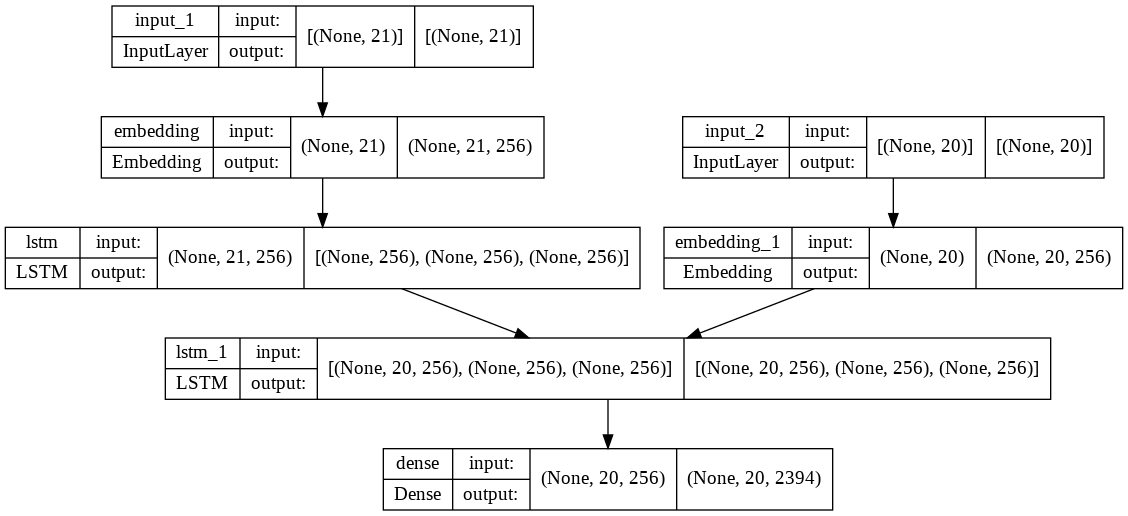

In [15]:
from keras.utils.vis_utils import plot_model
plot_model(saved_model, to_file='modelsummary.png', show_shapes=True, show_layer_names=True)

In [16]:
encoder_inputs = saved_model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = saved_model.layers[4].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)
latent_dim = 256  # Note: may be need to save in drive as well


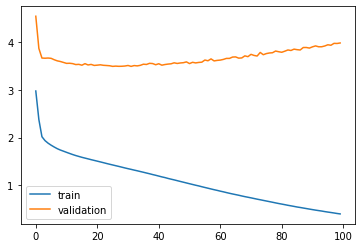

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])

## Inferencing on the models

### 1) Defining inference models
We create inference models which help in predicting translations.

**Encoder inference model** : Takes the English sentence as input and outputs LSTM states ( `h` and `c` ).

**Decoder inference model** : Takes in 2 inputs, one are the LSTM states ( Output of encoder model ), second are the French input seqeunces ( ones not having the `<start>` tag ). It will output the translations of the English sentence which we fed to the encoder model and its state values.





In [18]:

def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 256,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 256 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model


### 2) Making some translations


1.   First, we take a English sequence and predict the state values using `enc_model`.
2.   We set the state values in the decoder's LSTM.
3.   Then, we generate a sequence which contains the `<start>` element.
4.   We input this sequence in the `dec_model`.
5.   We replace the `<start>` element with the element which was predicted by the `dec_model` and update the state values.
6.   We carry out the above steps iteratively till we hit the `<end>` tag or the maximum sequence length.







In [19]:

def str_to_tokens( sentence : str ):
    words = sentence.lower().split()
    tokens_list = list()
    for word in words:
          print("word ", word,hindi_word_dict.get(word,1) )
          my_word=  hindi_word_dict.get(word,1)
          tokens_list.append(my_word) 
  
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=max_input_length , padding='post')


In [20]:

enc_model , dec_model = make_inference_models()

#encoder_input_data.shape[0] 
for epoch in range(1 ):
    states_values = enc_model.predict( str_to_tokens("मुझे खाने से प्यार है" ) )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = eng_word_dict['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in eng_word_dict.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
        
        if sampled_word == 'end' or len(decoded_translation.split()) > max_output_length:
            stop_condition = True
            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    # print("Decoded Traslation ", decoded_translation )
    print(f"{bcolors.OKGREEN}Decoded Traslation: { decoded_translation}{bcolors.ENDC}")

    

word  मुझे 8
word  खाने 266
word  से 6
word  प्यार 250
word  है 9


Decoded Traslation:  i'm not a doctor end


### Save Encoder and Decoder Parameters

In [21]:
%cd "drive/MyDrive/Machine Learning/GitHub Projects/machine-translation/models/"
model_name = str(lines.count().eng)
!mkdir $model_name
!ls
# save encoder model
enc_model.save( model_name+'/enc_model.h5' ) 
# save decoder model
dec_model.save( model_name+'/dec_model.h5' ) 
# save  model
saved_model.save( model_name+'/model.h5' ) 

/content/drive/MyDrive/Machine Learning/GitHub Projects/machine-translation/models
1000  2908  _about.txt	hin-eng.zip  hin.txt  modelsummary.png


In [22]:
# encoder parameters
encoder_parameters={
    'max_encoder_seq_length': max_input_length,
    'num_encoder_tokens': num_hindi_tokens,
    
   
}
encoder_dictionary=  hindi_word_dict


# decoder parameters
decoder_parameters={
    'max_decoder_seq_length':  max_output_length,
    'num_decoder_tokens': num_eng_tokens,

}

decoder_dictionary=  eng_word_dict



In [23]:
parameters=model_name+"/parameters/"
dictionaries=model_name+"/dictionaries/"
!mkdir $parameters
!mkdir $dictionaries


In [24]:
import pickle
paramters_path=parameters
dictionaries_path=dictionaries

# save encoder parameter
with open(paramters_path+'encoder_parameters.pickle', 'wb') as handle:
    pickle.dump(encoder_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save encoder dictionary
with open(dictionaries_path+'encoder_dictionary.pickle', 'wb') as handle:
    pickle.dump(encoder_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save encoder parameter
with open(paramters_path+'decoder_parameters.pickle', 'wb') as handle:
    pickle.dump(decoder_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save encoder parameter
with open(dictionaries_path+'decoder_dictionary.pickle', 'wb') as handle:
    pickle.dump(decoder_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)    

